In [388]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from string2string.alignment import LongestCommonSubsequence, LongestCommonSubstring
from string2string.distance import JaccardIndex
from string2string.misc.default_tokenizer import Tokenizer
import numpy as np

from sklearn.model_selection import train_test_split

In [403]:
generated = pd.read_csv("../data/generated_outputs.csv")
# generated = generated[temperatures].melt().rename({"variable": "temperature", "value": "text"}, axis=1)

In [404]:
original = pd.read_csv("../summaries.csv")

In [429]:
new = pd.read_csv("../data/processed_responses_with_predictions.csv").drop("HITId", axis=1)

In [485]:
new = pd.read_csv("../data/processed_responses_with_predictions2.csv").drop("HITId", axis=1)

In [406]:
qids = pd.read_csv("../data/qids.csv")

In [407]:
# temperatures = [str(k) for k in [0.3, 0.5, 0.7, 0.9, 1]]
temperatures = [str(k) for k in [0.7, 0.9]]

In [408]:
def extract_answer(text):
    pattern = r"<FreeText>(.*?)</FreeText>"
    matches = re.findall(pattern, text, re.DOTALL)

    return matches[1]
original["Answer"] = original["Answer"].apply(lambda x: extract_answer(x))

In [409]:
# generated["texts"] = generated["text"].apply(lambda x: x[4:20]).str.lower()
# qids["question"] = qids["question"].apply(lambda x: x[4:20]).str.lower()

In [410]:
# new["original_text"] = new["original_text"].apply(lambda x: x[4:20]).str.lower()

In [411]:
original = original[["Question", "Answer"]]

In [412]:
len(qids["HITId"].unique())

16

In [413]:
new["match_on"] = new["original_text"].apply(lambda x: " ".join(x.split()[0:3]))
qids["match_on"] = qids["question"].apply(lambda x: " ".join(x.split()[0:3]))

In [414]:
new = new.merge(qids, on="match_on")

In [415]:
abstracts = new[["original_text", "HITId"]]

In [416]:
new = new[["HITId","text", "predicted"]]

In [422]:
abstracts = abstracts.drop_duplicates().reset_index(drop=True)

In [424]:
# new = new[new["text"].map(len) > 150]

In [449]:
def prepare_for_finetuning(gen, real, abstracts):
    real = real.rename({"Question":"HITId", "Answer":"text"}, axis=1)
    gen = gen[["HITId", "text"]]
    
    # add labels
    real["labels"] = "real"
    real["class"] = "old-summaries"
    gen["labels"] = "synthetic"
    gen["class"] = "gen-summaries"

    abstracts["labels"] = "real"
    abstracts["class"] = "abstract"
    abstracts = abstracts.rename({"original_text":"text"}, axis=1)

    return pd.concat([real, gen, abstracts], axis=0).sample(frac=1)


for_training = prepare_for_finetuning(generated, original, abstracts)


/tmp/ipykernel_2799387/1136345126.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen["labels"] = "synthetic"


In [467]:
for_training[for_training["class"]=="abstract"]

,HITId,text,labels,class
15,NEJMoa1304127,Global Sodium Consumption and Death from Cardi...,real,abstract
3,NEJMoa1003833,Azithromycin and the Risk of Cardiovascular De...,real,abstract
13,NEJMoa072761,Effect of Rosiglitazone on the Risk of Myocard...,real,abstract
9,NEJMoa1014296,Changes in Diet and Lifestyle and Long-Term We...,real,abstract
7,NEJMoa1200303,Primary Prevention of Cardiovascular Disease w...,real,abstract
6,NEJMoa1206809,Effect of Three Decades of Screening Mammograp...,real,abstract
12,NEJMoa1112010,Association of Coffee Drinking with Total and ...,real,abstract
1,NEJMoa1000727,Effect of Screening Mammography on Breast-Canc...,real,abstract
5,NEJMoa1103507,Exemestane for Breast-Cancer Prevention in Pos...,real,abstract
4,NEJMoa1003114,Effect of Sibutramine on Cardiovascular Outcom...,real,abstract


In [451]:
for_training.to_json("../data/base.json", orient="records", indent=2)

In [208]:
# transductive
train, test = train_test_split(for_training)

In [196]:
# inductive

all_questions = list(for_training["HITId"].unique())
train_questions = np.random.choice(all_questions, 12)
q_set = set(all_questions)
test_questions = list(q_set - set(train_questions))

train = for_training[for_training["HITId"].isin(train_questions)][["text", "labels"]]
test = for_training[for_training["HITId"].isin(test_questions)][["text", "labels"]]

In [198]:
mapping = {"synthetic": 0, "real": 1}

In [199]:
labels = ["synthetic", "real"]

In [200]:
def _label_preprocessing(label):
    """Preprocessing the labels"""

    if isinstance(label, int):
        label = idx_to_label_mapper()[label]

    label_list = [0] * len(labels)
    label_list[labels.index(label)] = 1
    return label_list


def label_to_idx_mapper():
    assert labels is not None, "Labels are not set"

    return {label: idx for idx, label in enumerate(labels)}

In [202]:
import torch

for idx, item in train.iterrows():
    label = item['labels']
    print(f'Item #{idx}, Label type: {type(_label_preprocessing(label))}')

    if isinstance(label, int):
        try:
            item['labels'] = torch.tensor(_label_preprocessing(label), dtype=torch.float32)
        except TypeError as e:
            print(f"Error occurred at item #{idx}: {e}")
    else:
        print(f"Unexpected type at item #{idx}, expected int, got {type(label)}. Skipping conversion...")

Item #113, Label type: <class 'list'>
Unexpected type at item #113, expected int, got <class 'str'>. Skipping conversion...
Item #126, Label type: <class 'list'>
Unexpected type at item #126, expected int, got <class 'str'>. Skipping conversion...
Item #108, Label type: <class 'list'>
Unexpected type at item #108, expected int, got <class 'str'>. Skipping conversion...
Item #76, Label type: <class 'list'>
Unexpected type at item #76, expected int, got <class 'str'>. Skipping conversion...
Item #292, Label type: <class 'list'>
Unexpected type at item #292, expected int, got <class 'str'>. Skipping conversion...
Item #115, Label type: <class 'list'>
Unexpected type at item #115, expected int, got <class 'str'>. Skipping conversion...
Item #74, Label type: <class 'list'>
Unexpected type at item #74, expected int, got <class 'str'>. Skipping conversion...
Item #124, Label type: <class 'list'>
Unexpected type at item #124, expected int, got <class 'str'>. Skipping conversion...
Item #70, La

In [62]:
# train, test = train_test_split(for_training)

In [212]:
train.to_json("../data/train.json", orient="records", indent=2)
test.to_json("../data/test.json", orient="records", indent=2)

In [60]:
# generated = generated[generated["variable"].str.contains("0.7|1")]

In [691]:
drop = [20,22, 26, 47]

In [692]:
new = new[~new.index.isin(drop)]

In [88]:
def measure_subseq_length(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    lcsubsequence = LongestCommonSubsequence()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [89]:
def measure_substr_length(gen, k):
    lcsubsequence = LongestCommonSubstring()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [90]:
def measure_jaccard_sim(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    jaccard_distance = JaccardIndex()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    jaccard_dist_score = jaccard_distance.compute(gen_token, k_token)

    return jaccard_dist_score

In [43]:
ids = new["HITId"].unique()

In [47]:
new_sim = []
original_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["text"]
        for j, row2 in new_.iterrows():
            summary = row2["text"]
            new_sim.append([idx, measure_subseq_length(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_sim.append([idx, measure_subseq_length(gen_text, summary)])
        

In [51]:
new_sub_sim = []
original_sub_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["text"]
        for j, row2 in new_.iterrows():
            summary = row2["text"]
            new_sub_sim.append([idx, measure_substr_length(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_sub_sim.append([idx, measure_substr_length(gen_text, summary)])
        

In [53]:
new_jaccard_sim = []
original_jaccard_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["text"]
        for j, row2 in new_.iterrows():
            summary = row2["text"]
            new_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        

In [54]:
og_sim = pd.DataFrame(original_sim)
new_sim = pd.DataFrame(new_sim)

In [60]:
new_sim["copied"] = new["predicted"]

In [61]:
og_j = pd.DataFrame(original_jaccard_sim)
new_j = pd.DataFrame(new_jaccard_sim)

In [62]:
new_j["copied"] = new["predicted"]

In [63]:
og_s = pd.DataFrame(original_sub_sim)
new_s = pd.DataFrame(new_sub_sim)

In [64]:
new_s["copied"] = new["predicted"]

In [565]:
new_sim[1].mean()

36.256410256410255

In [566]:
og_sim[1].mean()

37.015625

Text(0.5, 0, 'Longest matching subsequence')

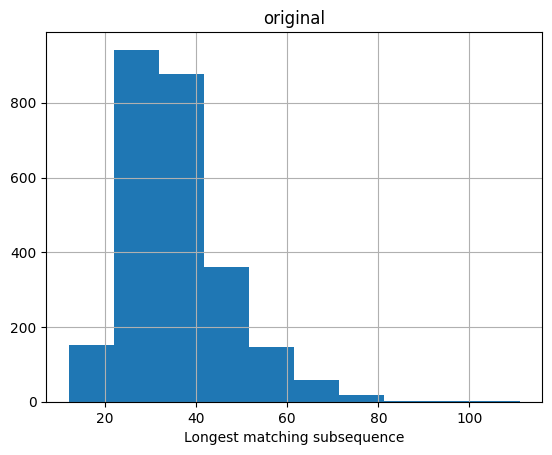

In [65]:
og_sim[og_sim[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Longest matching subsequence')

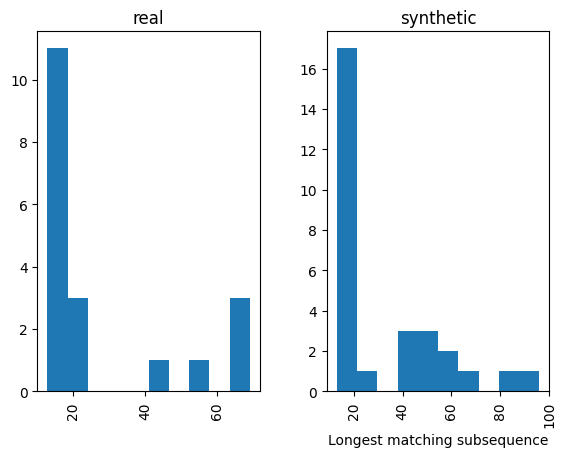

In [66]:
new_sim[new_sim[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Jaccard')

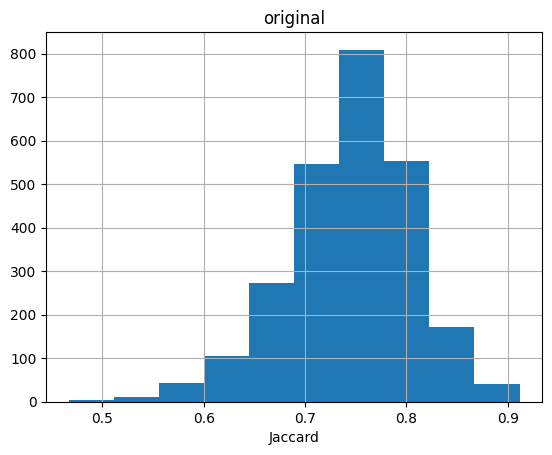

In [67]:
og_j[og_j[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Jaccard")

Text(0.5, 0, 'Jaccard')

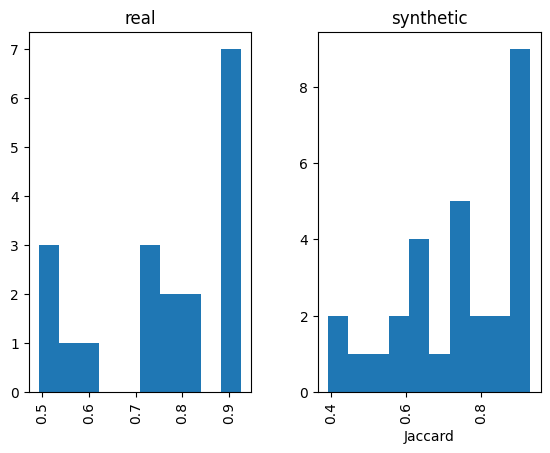

In [68]:
new_j[new_j[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Jaccard")

Text(0.5, 0, 'Longest matching substring')

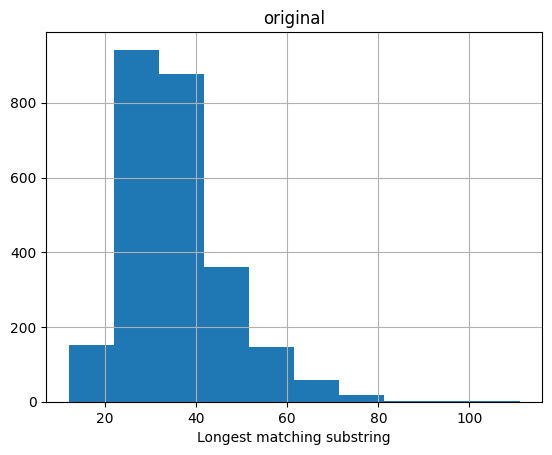

In [69]:
og_sim[og_sim[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Longest matching substring")

Text(0.5, 0, 'Longest matching substring')

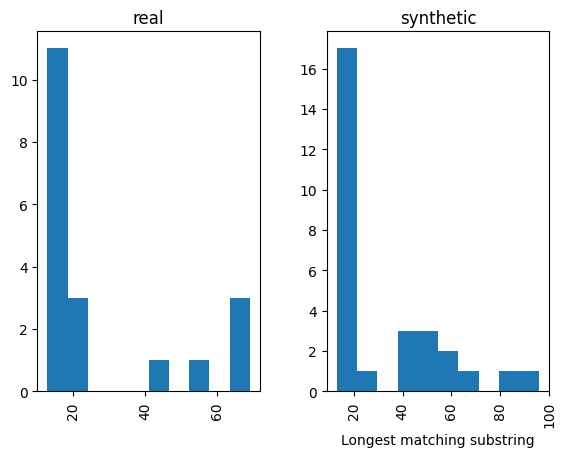

In [70]:
new_sim[new_sim[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Longest matching substring")

# HERE

In [486]:
copied = new[new["copied"] == True]

In [487]:
common_substr = []
for i, row in copied.iterrows():
    common_substr.append(measure_substr_length(row["original_text"], row["text"]))

In [488]:
copied["common_substr"] = common_substr

/tmp/ipykernel_2799387/3299094430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied["common_substr"] = common_substr


In [489]:
tokenizer = Tokenizer(word_delimiter=' ')

copied["original_length"] = copied["original_text"].apply(lambda x: len(tokenizer.tokenize(x)))
copied["text_length"] = copied["text"].apply(lambda x: len(tokenizer.tokenize(x)))

/tmp/ipykernel_2799387/622417631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied["original_length"] = copied["original_text"].apply(lambda x: len(tokenizer.tokenize(x)))
/tmp/ipykernel_2799387/622417631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied["text_length"] = copied["text"].apply(lambda x: len(tokenizer.tokenize(x)))


In [490]:
copied["prop_copied"] = copied["common_substr"] / copied["text_length"]

/tmp/ipykernel_2799387/2882559119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copied["prop_copied"] = copied["common_substr"] / copied["text_length"]


In [491]:
copied.sort_values(by = "prop_copied").sort_values(by = "prop_copied")

,original_text,key_strokes,datetime,text,copied,predicted,common_substr,original_length,text_length,prop_copied
27,Changes in Diet and Lifestyle and Long-Term We...,Control v paste,"['2023-06-01T09:00:53.144Z', '2023-06-01T09:00...",Diet and lifestyle factors contribute to devel...,True,real,3,322,127,0.023622
16,Exemestane for Breast-Cancer Prevention in Pos...,paste paste,"[None, None]",The benefits of medicines are the helpful effe...,True,real,2,326,83,0.024096
19,Effect of Three Decades of Screening Mammograp...,Control Control Control Control Control Contro...,"['2023-06-01T06:55:12.775Z', '2023-06-01T06:55...",The inverse association between coffee consump...,True,synthetic,2,353,70,0.028571
2,Comparison of Weight-Loss Diets with Different...,copy paste,"[None, None]",In this two-year study of 811 overweight adult...,True,real,3,330,84,0.035714
21,Primary Prevention of Cardiovascular Disease w...,Control c copy c copy Control v paste Backspac...,"['2023-06-01T08:54:38.070Z', '2023-06-01T08:54...",Primary prevention refers to the steps taken b...,True,real,2,283,52,0.038462
28,Changes in Diet and Lifestyle and Long-Term We...,copy copy copy copy paste,"[None, None, None, None, None]",This study examined the relationship between d...,True,synthetic,4,322,103,0.038835
5,Effect of Screening Mammography on Breast-Canc...,copy paste Control v paste,"[None, None, '2023-06-01T06:40:06.904Z', '2023...",The effect of screening mammography on breast ...,True,synthetic,5,282,123,0.040650
7,"First Results of Phase 3 Trial of RTS,S/AS01 M...",copy Control v paste,"[None, '2023-06-01T06:44:19.371Z', '2023-06-01...",The first results of a phase 3 trial for the R...,True,synthetic,9,319,154,0.058442
20,Effect of Three Decades of Screening Mammograp...,copy copy paste,"[None, None, None]",Screening mammography has been used in the Uni...,True,synthetic,8,353,136,0.058824
11,Azithromycin and the Risk of Cardiovascular De...,copy Control V paste,"[None, '2023-06-01T06:40:30.604Z', '2023-06-01...","In a study of a Tennessee Medicaid cohort, it ...",True,synthetic,8,298,121,0.066116


In [499]:
copied=copied.drop_duplicates()

In [500]:
copied.iloc[13][["original_text", "text"]].values

array(['Exemestane for Breast-Cancer Prevention in Postmenopausal Women\n\nTamoxifen and raloxifene have limited patient acceptance for primary prevention of breast cancer. Aromatase inhibitors prevent more contralateral breast cancers and cause fewer side effects than tamoxifen in patients with early-stage breast cancer.\n\nIn a randomized, placebo-controlled, double-blind trial of exemestane designed to detect a 65% relative reduction in invasive breast cancer, eligible postmenopausal women 35 years of age or older had at least one of the following risk factors; 60 years of age or older; Gail 5-year risk score greater than 1.66% (chances in 100 of invasive breast cancer developing within 5 years); prior atypical ductal or lobular hyperplasia or lobular carcinoma in situ; or ductal carcinoma in situ with mastectomy. Toxic effects and health-related and menopause-specific qualities of life were measured.\n\nA total of 4560 women for whom the median age was 62.5 years and the median Gai

In [503]:
real_data

prop_copied
0.0    3
1.0    3
3.0    4
4.0    3
5.0    4
6.0    1
7.0    2
8.0    6
Name: prop_copied, dtype: int64

In [509]:
concatted = pd.concat([real_data, synthetic_data], axis=1).fillna(0)

,real,synthetic
prop_copied,,
0.0,3.0,11.0
1.0,3.0,2.0
2.0,0.0,1.0
3.0,4.0,0.0
4.0,3.0,0.0
5.0,4.0,0.0
6.0,1.0,0.0
7.0,2.0,0.0
8.0,6.0,1.0


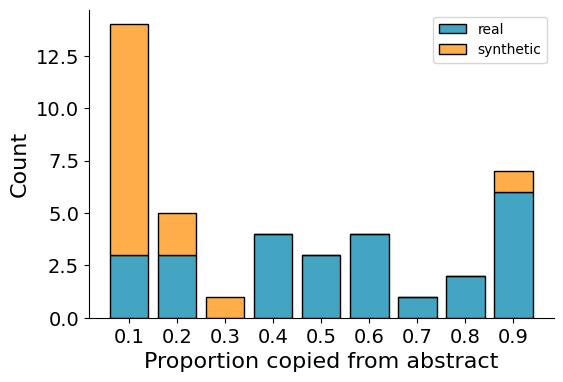

In [531]:

proportion_copied = copied.sort_values(by = "prop_copied")

# Create bins for 'prop_copied' values
bins = np.linspace(proportion_copied["prop_copied"].min(), proportion_copied["prop_copied"].max(), 10)

# Cut 'prop_copied' into bins and count the number of 'real' and 'synthetic' in each bin
real_data = proportion_copied[proportion_copied["predicted"] == "real"]["prop_copied"].groupby(pd.cut(proportion_copied[proportion_copied["predicted"] == "real"]["prop_copied"], bins, labels=False)).count()
synthetic_data = proportion_copied[proportion_copied["predicted"] == "synthetic"]["prop_copied"].groupby(pd.cut(proportion_copied[proportion_copied["predicted"] == "synthetic"]["prop_copied"], bins, labels=False)).count()

real_data.fillna(0, inplace=True)
synthetic_data.fillna(0, inplace=True)

concatted = pd.concat([real_data, synthetic_data], axis=1).fillna(0)
concatted.columns = ["real", "synthetic"]
concatted = concatted.sort_index()
concatted.index = np.round(concatted.index / 10 + .1, 1)

fig, ax = plt.subplots(figsize=(6,4))


# Plot 'real' data
ax.bar(concatted.index.astype(str), concatted["real"], label='real', color='#44a5c2', edgecolor = "black")

# Plot 'synthetic' data
ax.bar(concatted.index.astype(str), concatted["synthetic"], bottom=concatted["real"], label='synthetic', color='#ffae49', edgecolor = "black")

ax.set_ylabel("Count", fontsize=16)
ax.set_xlabel("Proportion copied from abstract", fontsize=16)
ax.tick_params(labelsize=14)
ax.spines[['right', 'top']].set_visible(False)
ax.legend()



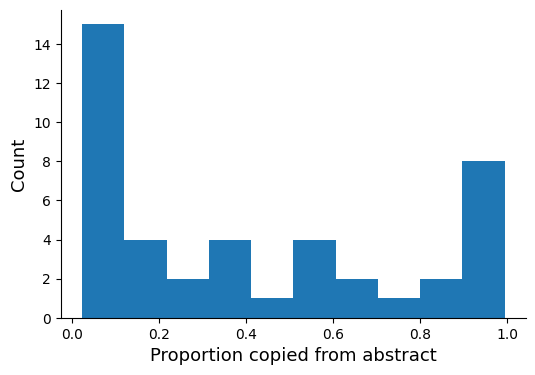

In [130]:
proportion_copied = copied.sort_values(by = "prop_copied")["prop_copied"]

fig, ax = plt.subplots(figsize=(6,4))

ax.hist(proportion_copied, color="tab:blue")
ax.set_ylabel("Count", fontsize=13)
ax.set_xlabel("Proportion copied from abstract", fontsize=13)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig("../visuals/proportion_copied_from_abstract.pdf", dpi=300, bbox_inches="tight")